In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm


### Load CSV

In [2]:
CSV_PATH  = "raw_data/airsim_trajectory.csv"
DF        = pd.read_csv(CSV_PATH)

# keep positions (x,y,z); drop the first few rows if velocities had NaNs
df = DF[["POS_X", "POS_Y", "POS_Z"]].reset_index(drop=True)
print(df.head())


      POS_X         POS_Y    POS_Z
0  0.000163  1.398570e-12 -4.95733
1  0.001979  2.758130e-11 -4.94510
2  0.006992  1.201170e-10 -4.93691
3  0.016112  3.180450e-10 -4.93257
4  0.029758  6.557500e-10 -4.93101


### Sliding‑window dataset
(past 10 s → predict next 20 s @ 10 Hz → 100 + 200 steps)

In [3]:
PAST_STEPS  = 100   # 10 s history  (10 Hz)
FUTURE_STEPS= 200   # 20 s horizon

class TrajDataset(Dataset):
    def __init__(self, df):
        self.data = df.values.astype(np.float32)
        self.N    = len(df) - (PAST_STEPS + FUTURE_STEPS)

    def __len__(self): return self.N

    def __getitem__(self, idx):
        start   = idx
        past    = self.data[start : start+PAST_STEPS]           # (100,3)
        future  = self.data[start+PAST_STEPS : start+PAST_STEPS+FUTURE_STEPS]
        return torch.from_numpy(past), torch.from_numpy(future)

# split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

train_ds = TrajDataset(train_df)
test_ds  = TrajDataset(test_df)

train_dl = DataLoader(train_ds, 64, shuffle=True)
test_dl  = DataLoader(test_ds, 64, shuffle=False)


### Plot one sample window to verify continuity

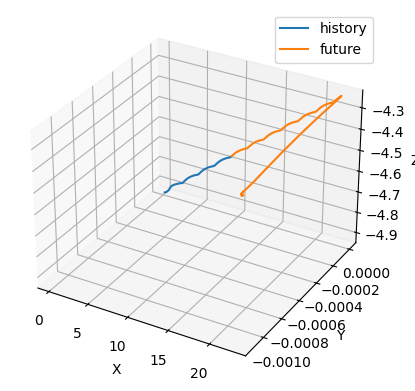

In [14]:
past, fut = train_ds[10]

fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
ax.plot(past[:,0], past[:,1], past[:,2], label="history")
ax.plot(fut[:,0],  fut[:,1],  fut[:,2],  label="future")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z"); ax.legend()
plt.show()


### Transformer model

In [5]:
class TrajTransformer(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=4):
        super().__init__()
        self.in_proj  = nn.Linear(3, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.encoder  = nn.TransformerEncoder(encoder_layer, num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead)
        self.decoder  = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out_proj = nn.Linear(d_model, 3)

    def forward(self, past):
        """
        past: (B,P,3) -> future: (B,F,3)
        """
        B,P,_ = past.shape
        src = self.in_proj(past)                     # (B,P,d)
        src = src.permute(1,0,2)                    # (P,B,d) for transformer

        memory = self.encoder(src)

        # prepare zero‑inputs for decoder (teacher forcing not used here)
        tgt = torch.zeros(FUTURE_STEPS, B, memory.size(-1), device=past.device)
        out = self.decoder(tgt, memory)             # (F,B,d)
        out = self.out_proj(out).permute(1,0,2)     # (B,F,3)
        return out


### Training loop


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = TrajTransformer().to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn= nn.MSELoss()

EPOCHS = 20
for ep in range(1, EPOCHS+1):
    model.train(); total = 0
    for past,fut in tqdm(train_dl, desc=f"Epoch {ep}/{EPOCHS}"):
        past,fut = past.to(device), fut.to(device)
        pred = model(past)
        loss = loss_fn(pred, fut)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*len(past)
    print(f"train MSE: {total/len(train_ds):.6f}")


e:\Research\UAV Trajectory Prediction\LearnProject1\AirEnv\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/20: 100%|██████████| 23/23 [01:11<00:00,  3.10s/it]


train MSE: 91.963265


Epoch 2/20: 100%|██████████| 23/23 [01:12<00:00,  3.15s/it]


train MSE: 77.359999


Epoch 3/20: 100%|██████████| 23/23 [01:20<00:00,  3.50s/it]


train MSE: 67.437472


Epoch 4/20: 100%|██████████| 23/23 [01:33<00:00,  4.06s/it]


train MSE: 58.137923


Epoch 5/20: 100%|██████████| 23/23 [01:18<00:00,  3.39s/it]


train MSE: 49.598219


Epoch 6/20: 100%|██████████| 23/23 [01:16<00:00,  3.33s/it]


train MSE: 41.864055


Epoch 7/20: 100%|██████████| 23/23 [01:18<00:00,  3.41s/it]


train MSE: 34.903388


Epoch 8/20: 100%|██████████| 23/23 [01:19<00:00,  3.48s/it]


train MSE: 28.694846


Epoch 9/20: 100%|██████████| 23/23 [01:13<00:00,  3.19s/it]


train MSE: 23.222753


Epoch 10/20: 100%|██████████| 23/23 [01:11<00:00,  3.11s/it]


train MSE: 18.475853


Epoch 11/20: 100%|██████████| 23/23 [01:10<00:00,  3.06s/it]


train MSE: 14.433877


Epoch 12/20: 100%|██████████| 23/23 [01:11<00:00,  3.09s/it]


train MSE: 11.066108


Epoch 13/20: 100%|██████████| 23/23 [01:12<00:00,  3.13s/it]


train MSE: 8.329369


Epoch 14/20: 100%|██████████| 23/23 [01:14<00:00,  3.24s/it]


train MSE: 6.157410


Epoch 15/20: 100%|██████████| 23/23 [01:14<00:00,  3.25s/it]


train MSE: 4.483237


Epoch 16/20: 100%|██████████| 23/23 [01:11<00:00,  3.10s/it]


train MSE: 3.227825


Epoch 17/20: 100%|██████████| 23/23 [01:12<00:00,  3.17s/it]


train MSE: 2.313647


Epoch 18/20: 100%|██████████| 23/23 [01:13<00:00,  3.19s/it]


train MSE: 1.640837


Epoch 19/20: 100%|██████████| 23/23 [01:14<00:00,  3.23s/it]


train MSE: 1.155663


Epoch 20/20: 100%|██████████| 23/23 [01:12<00:00,  3.15s/it]

train MSE: 0.833763


### Evaluation & RMSE

In [7]:
model.eval(); sqerr, n = 0, 0
with torch.no_grad():
    for past,fut in test_dl:
        past,fut = past.to(device), fut.to(device)
        pred = model(past)
        sqerr += ((pred - fut)**2).sum().item()
        n     += fut.numel()
rmse = np.sqrt(sqerr / n)
print(f"Test RMSE (position units): {rmse:.4f}")


Test RMSE (position units): 0.6999


### Visualise a prediction

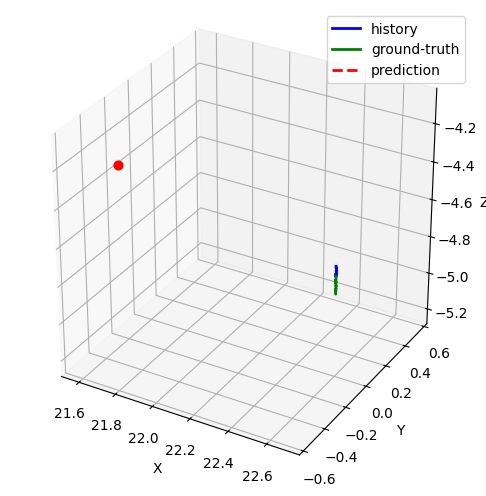

In [11]:
# -------- grab one window from the test set ----------
past, fut = test_ds[0]

# model → prediction
pred = model(past.unsqueeze(0).to(device)).squeeze(0)

# -------- convert to NumPy for Matplotlib -------------
past_np = past.numpy()
fut_np  = fut.numpy()
pred_np = pred.detach().cpu().numpy()   # ← detach!

# -------- 3‑D plot ------------------------------------
def set_equal_3d(ax, pts, margin=0.05):
    """
    Make 3‑D axes look cubic.
    pts: (N,3) array of all points to display.
    """
    # centre of the data
    x_mid, y_mid, z_mid = pts.mean(axis=0)
    # half‑range = max range / 2
    max_range = (pts.max(axis=0) - pts.min(axis=0)).max() / 2 + margin

    ax.set_xlim(x_mid - max_range, x_mid + max_range)
    ax.set_ylim(y_mid - max_range, y_mid + max_range)
    ax.set_zlim(z_mid - max_range, z_mid + max_range)
    try:                                # Matplotlib ≥ 3.4
        ax.set_box_aspect([1, 1, 1])
    except AttributeError:
        pass                            # fallback: older versions just use limits

# ---------- plotting ----------
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(past_np[:,0], past_np[:,1], past_np[:,2],
        color='blue', linewidth=2, label='history')
ax.plot(fut_np[:,0],  fut_np[:,1],  fut_np[:,2],
        color='green', linewidth=2, label='ground‑truth')
ax.plot(pred_np[:,0], pred_np[:,1], pred_np[:,2],
        color='red', linestyle='--', linewidth=2, label='prediction')
ax.scatter(pred_np[-1,0], pred_np[-1,1], pred_np[-1,2],
           color='red', s=40)

# equal aspect & tight cube
all_pts = np.vstack([past_np, fut_np, pred_np])
set_equal_3d(ax, all_pts)

ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend(); plt.show()
